## Key Takeaways

### For NNs using Images
- Convolutions are helpful
- SGD isn't as good as newer optimizers like Adam and NesterovAdam - https://towardsdatascience.com/types-of-optimization-algorithms-used-in-neural-networks-and-ways-to-optimize-gradient-95ae5d39529f
- normalization is helpful (both of the features and the output) and helps prevent divergence
- batch normalization works well after the activation https://github.com/ducha-aiki/caffenet-benchmark/blob/master/batchnorm.md
- batch normalization should go before dropout
- dropout may be best if used only once after all the BN layers to avoid variance shift https://arxiv.org/pdf/1801.05134.pdf. When we trained with BN and dropoout in each set of layers the loss variance jumped a lot. If dropout only after all BN layers, loss doesn't jump around.
- Need to make layers deeper to get the generalization benefit of BN and dropout


### Generally
- Never trust the data blindly

## Setup

### Imports

In [1]:
%matplotlib inline
from pandas.io.parsers import read_csv
from sklearn.model_selection import train_test_split

import os
import pickle

import numpy as np
import matplotlib.pyplot as plt

from keras.models import Sequential,load_model
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from keras.optimizers import Nadam, Adam
from keras.callbacks import EarlyStopping, Callback, History
from keras.applications.inception_v3  import InceptionV3

from tensorflow.python.client import device_lib

from augmentdata.CustImageDataGenerator import CustImageDataGenerator,CustNumpyArrayIterator

print(device_lib.list_local_devices()) # confirm using GPU

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11878718471274896296
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 689536703196342759
physical_device_desc: "device: XLA_GPU device"
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 8187469445305412149
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11286970368
locality {
  bus_id: 1
}
incarnation: 18274482025576484955
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:1e.0, compute capability: 3.7"
]


### Constants

In [6]:
TRAIN_DATA = '/home/ubuntu/w207/data/training.csv'
TEST_DATA = '/home/ubuntu/w207/data/test.csv'
IMAGE_ROWS = 96
IMAGE_COLS = 96
INPUT_SHAPE = (IMAGE_ROWS, IMAGE_COLS, 1)
RETRAIN = False

### Load the Data

In [7]:
def loader(test=False, seed=None, keeplabels=None):
    if seed:
        np.random.seed(seed)
    fileloc = TEST_DATA if test else TRAIN_DATA
    
    df = read_csv(fileloc)
    
    df['Image'] = df['Image'].apply(lambda x: np.fromstring(x, sep=' '))
    
    if keeplabels:
        df = df[list(keeplabels) + ['Image']]
        
    df = df.dropna() # drop rows with missing labels
    
    X = np.vstack(df['Image'])
    # by pixel across the whole dataset subtract mean and divide by stdev
    X = X - np.tile(np.mean(X,axis=0),(X.shape[0],1))
    X = X / np.tile(np.std(X,axis=0),(X.shape[0],1))
    X = X.astype(np.float32)
    
    if not test:
        y = df[df.columns.difference(['Image'])].values
        y = y.astype(np.float32)
        y = (y - 48) / 48 # this helps, but tanh on output doesnt
        shuffle = np.random.permutation(np.arange(X.shape[0]))
        X, y = X[shuffle], y[shuffle]
    else:
        y = None
    
    X = X.reshape(-1, 96, 96, 1)

    return X, y, df.columns.difference(['Image'])


In [8]:
X, y, labels = loader(seed=42)
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.2,
                                                        random_state=42)
data=[X_train, X_test, y_train, y_test]

### Plot an Example Image

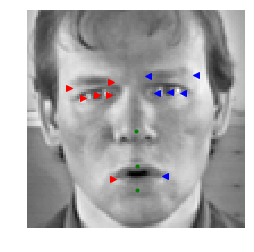

In [9]:
def plot_image(image, points, labels=list(labels), title=None):
    """Helper function to plot images"""
    plt.figure(figsize=(4,4))
    plt.imshow(np.reshape(image,(96,96)), cmap = 'gray')
    x = 0
    for i, label in enumerate(labels):
        if label[-1]=='x':
            x = points[i]
        else:
            if label in ['left_eye_center_y',
                         'left_eye_inner_corner_y', 
                         'left_eye_outer_corner_y', 
                         'left_eyebrow_inner_end_y', 
                         'left_eyebrow_outer_end_y',
                         'mouth_left_corner_y'
                        ]:
                plt.plot(x, points[i], 'b<')
            elif label in ['right_eye_center_y',
                         'right_eye_inner_corner_y', 
                         'right_eye_outer_corner_y', 
                         'right_eyebrow_inner_end_y', 
                         'right_eyebrow_outer_end_y',
                          'mouth_right_corner_y']:
                plt.plot(x, points[i], 'r>')
            else:
                plt.plot(x, points[i],'g.')
    plt.axis('off')
    if title:
        plt.title(title)



plot_image(X_train[0], 48*y_train[0]+48, labels)


### Model Fitting Function

In [10]:
def fit_model(model, data, modelname,
              generator=None,retrain=RETRAIN,
              epochs=1000, patience=1000):
    if retrain or not os.path.exists('/home/ubuntu/w207/saved-models/' + modelname + '.h5'):
        X_train = data[0]
        y_train = data[2]
        if len(data) == 4:
            valid_dat = (data[1], data[3])
        else:
            valid_dat = None
        
        
        model.compile(loss='mse', optimizer=Adam())
        
        if valid_dat:
            earlystop = EarlyStopping(monitor='val_loss',
                                     patience=patience,
                                     verbose=1,
                                     mode="auto")
            callbacks = [earlystop]
        else:
            callbacks = None
        
        if generator:
            history = model.fit_generator(generator,
                        epochs=epochs,
                        steps_per_epoch=data[0].shape[0]//32,
                        callbacks=callbacks,
                        validation_data=valid_dat
             )
        else:
            history = model.fit(X_train, y_train,
                                epochs=epochs,
                                batch_size=32,
                                callbacks=callbacks,
                                validation_data=valid_dat
                     )
        model.save('/home/ubuntu/w207/saved-models/'+ modelname + '.h5')
        with open('/home/ubuntu/w207/saved-models/histories/'+ modelname +'_hist','wb') as file_pi:
            pickle.dump(history.history, file_pi)
        history = history.history
    else:
        model = load_model('/home/ubuntu/w207/saved-models/'+modelname+'.h5')
        history = pickle.load(open( "/home/ubuntu/w207/saved-models/histories/" + modelname + '_hist',
                                   "rb" ))
        
    return history, model

### Helper function to plot the loss

In [11]:
def plot_loss(hists, names):
    colordict = {
        0 : 'b',
        1 : 'g',
        2 : 'r',
        3 : 'o',
        4 : 'p'
    }
    
    for i, hist in enumerate(hists):
        plt.plot([np.sqrt(x) * 48 for x in hist['loss']],
                 color=colordict[i],
                 label="train " + names[i])
        plt.plot([np.sqrt(x) * 48 for x in hist['val_loss']],
                 color=colordict[i],
                 linestyle=':',
                 label="valid " + names[i])
        plt.grid()
        plt.legend()
        plt.xlabel("epoch")
        plt.ylabel("RMSE")
        plt.yscale("log")
    plt.show()

## Models 
### 1 Dense Hidden Layer with 100 units

In [18]:
model1 = Sequential()
model1.add(Flatten(input_shape=INPUT_SHAPE))
model1.add(Dense(100, activation='relu'))
model1.add(Dense(30))
print(model1.summary())
model1_hist, model1 = fit_model(model1, data, '1dense100neuronlayer', retrain = True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 100)               921700    
_________________________________________________________________
dense_8 (Dense)              (None, 30)                3030      
Total params: 924,730
Trainable params: 924,730
Non-trainable params: 0
_________________________________________________________________
None
Train on 1712 samples, validate on 428 samples
Epoch 1/1000
1712/1712 [==============================] - 2s 954us/step - loss: 2.2901 - val_loss: 0.9696
Epoch 2/1000
1712/1712 [==============================] - 0s 179us/step - loss: 0.9708 - val_loss: 0.7460
Epoch 3/1000
1712/1712 [==============================] - 0s 180us/step - loss: 0.6547 - val_loss: 0.6967
Epoch 4/1000
1712/1712 [======

1712/1712 [==============================] - 0s 184us/step - loss: 0.0230 - val_loss: 0.0494
Epoch 71/1000
1712/1712 [==============================] - 0s 185us/step - loss: 0.1079 - val_loss: 0.1831
Epoch 72/1000
1712/1712 [==============================] - 0s 180us/step - loss: 0.2109 - val_loss: 0.1572
Epoch 73/1000
1712/1712 [==============================] - 0s 183us/step - loss: 0.0647 - val_loss: 0.0299
Epoch 74/1000
1712/1712 [==============================] - 0s 181us/step - loss: 0.0110 - val_loss: 0.0127
Epoch 75/1000
1712/1712 [==============================] - 0s 179us/step - loss: 0.0048 - val_loss: 0.0101
Epoch 76/1000
1712/1712 [==============================] - 0s 178us/step - loss: 0.0035 - val_loss: 0.0091
Epoch 77/1000
1712/1712 [==============================] - 0s 177us/step - loss: 0.0028 - val_loss: 0.0086
Epoch 78/1000
1712/1712 [==============================] - 0s 180us/step - loss: 0.0024 - val_loss: 0.0082
Epoch 79/1000
1712/1712 [==========================

Epoch 145/1000
1712/1712 [==============================] - 0s 179us/step - loss: 4.4633e-04 - val_loss: 0.0037
Epoch 146/1000
1712/1712 [==============================] - 0s 179us/step - loss: 4.7839e-04 - val_loss: 0.0038
Epoch 147/1000
1712/1712 [==============================] - 0s 177us/step - loss: 0.0015 - val_loss: 0.0061
Epoch 148/1000
1712/1712 [==============================] - 0s 180us/step - loss: 0.0018 - val_loss: 0.0046
Epoch 149/1000
1712/1712 [==============================] - 0s 180us/step - loss: 0.0016 - val_loss: 0.0038
Epoch 150/1000
1712/1712 [==============================] - 0s 177us/step - loss: 9.1458e-04 - val_loss: 0.0035
Epoch 151/1000
1712/1712 [==============================] - 0s 179us/step - loss: 6.9802e-04 - val_loss: 0.0037
Epoch 152/1000
1712/1712 [==============================] - 0s 179us/step - loss: 0.0083 - val_loss: 0.0172
Epoch 153/1000
1712/1712 [==============================] - 0s 178us/step - loss: 0.0100 - val_loss: 0.0041
Epoch 154/10

1712/1712 [==============================] - 0s 181us/step - loss: 8.1692e-04 - val_loss: 0.0025
Epoch 219/1000
1712/1712 [==============================] - 0s 179us/step - loss: 9.0806e-04 - val_loss: 0.0022
Epoch 220/1000
1712/1712 [==============================] - 0s 178us/step - loss: 8.3781e-04 - val_loss: 0.0021
Epoch 221/1000
1712/1712 [==============================] - 0s 180us/step - loss: 7.0200e-04 - val_loss: 0.0021
Epoch 222/1000
1712/1712 [==============================] - 0s 178us/step - loss: 6.5405e-04 - val_loss: 0.0021
Epoch 223/1000
1712/1712 [==============================] - 0s 180us/step - loss: 6.1894e-04 - val_loss: 0.0019
Epoch 224/1000
1712/1712 [==============================] - 0s 180us/step - loss: 6.7375e-04 - val_loss: 0.0021
Epoch 225/1000
1712/1712 [==============================] - 0s 181us/step - loss: 7.6051e-04 - val_loss: 0.0021
Epoch 226/1000
1712/1712 [==============================] - 0s 176us/step - loss: 7.4776e-04 - val_loss: 0.0022
Epoch 2

Epoch 293/1000
1712/1712 [==============================] - 0s 181us/step - loss: 0.0011 - val_loss: 0.0026
Epoch 294/1000
1712/1712 [==============================] - 0s 179us/step - loss: 0.0011 - val_loss: 0.0026
Epoch 295/1000
1712/1712 [==============================] - 0s 181us/step - loss: 0.0011 - val_loss: 0.0026
Epoch 296/1000
1712/1712 [==============================] - 0s 178us/step - loss: 0.0010 - val_loss: 0.0026
Epoch 297/1000
1712/1712 [==============================] - 0s 180us/step - loss: 9.7310e-04 - val_loss: 0.0025
Epoch 298/1000
1712/1712 [==============================] - 0s 184us/step - loss: 9.6659e-04 - val_loss: 0.0026
Epoch 299/1000
1712/1712 [==============================] - 0s 179us/step - loss: 9.5874e-04 - val_loss: 0.0025
Epoch 300/1000
1712/1712 [==============================] - 0s 178us/step - loss: 8.9710e-04 - val_loss: 0.0025
Epoch 301/1000
1712/1712 [==============================] - 0s 178us/step - loss: 8.7676e-04 - val_loss: 0.0025
Epoch 30

1712/1712 [==============================] - 0s 180us/step - loss: 2.9397e-04 - val_loss: 0.0020
Epoch 367/1000
1712/1712 [==============================] - 0s 180us/step - loss: 2.8080e-04 - val_loss: 0.0020
Epoch 368/1000
1712/1712 [==============================] - 0s 178us/step - loss: 2.8719e-04 - val_loss: 0.0020
Epoch 369/1000
1712/1712 [==============================] - 0s 179us/step - loss: 2.8933e-04 - val_loss: 0.0020
Epoch 370/1000
1712/1712 [==============================] - 0s 180us/step - loss: 3.0822e-04 - val_loss: 0.0020
Epoch 371/1000
1712/1712 [==============================] - 0s 177us/step - loss: 3.1737e-04 - val_loss: 0.0020
Epoch 372/1000
1712/1712 [==============================] - 0s 176us/step - loss: 2.8402e-04 - val_loss: 0.0020
Epoch 373/1000
1712/1712 [==============================] - 0s 180us/step - loss: 2.7723e-04 - val_loss: 0.0020
Epoch 374/1000
1712/1712 [==============================] - 0s 180us/step - loss: 3.4600e-04 - val_loss: 0.0021
Epoch 3

1712/1712 [==============================] - 0s 181us/step - loss: 8.6070e-04 - val_loss: 0.0021
Epoch 440/1000
1712/1712 [==============================] - 0s 179us/step - loss: 8.1046e-04 - val_loss: 0.0021
Epoch 441/1000
1712/1712 [==============================] - 0s 179us/step - loss: 9.0591e-04 - val_loss: 0.0021
Epoch 442/1000
1712/1712 [==============================] - 0s 182us/step - loss: 8.8245e-04 - val_loss: 0.0024
Epoch 443/1000
1712/1712 [==============================] - 0s 185us/step - loss: 0.0011 - val_loss: 0.0025
Epoch 444/1000
1712/1712 [==============================] - 0s 187us/step - loss: 0.0011 - val_loss: 0.0023
Epoch 445/1000
1712/1712 [==============================] - 0s 180us/step - loss: 9.8648e-04 - val_loss: 0.0024
Epoch 446/1000
1712/1712 [==============================] - 0s 181us/step - loss: 9.4871e-04 - val_loss: 0.0022
Epoch 447/1000
1712/1712 [==============================] - 0s 182us/step - loss: 0.0010 - val_loss: 0.0026
Epoch 448/1000
1712

Epoch 514/1000
1712/1712 [==============================] - 0s 180us/step - loss: 6.1179e-04 - val_loss: 0.0023
Epoch 515/1000
1712/1712 [==============================] - 0s 180us/step - loss: 6.3757e-04 - val_loss: 0.0024
Epoch 516/1000
1712/1712 [==============================] - 0s 178us/step - loss: 6.0397e-04 - val_loss: 0.0024
Epoch 517/1000
1712/1712 [==============================] - 0s 178us/step - loss: 5.8629e-04 - val_loss: 0.0023
Epoch 518/1000
1712/1712 [==============================] - 0s 178us/step - loss: 5.6360e-04 - val_loss: 0.0023
Epoch 519/1000
1712/1712 [==============================] - 0s 178us/step - loss: 5.5730e-04 - val_loss: 0.0024
Epoch 520/1000
1712/1712 [==============================] - 0s 179us/step - loss: 5.4948e-04 - val_loss: 0.0023
Epoch 521/1000
1712/1712 [==============================] - 0s 179us/step - loss: 5.3235e-04 - val_loss: 0.0023
Epoch 522/1000
1712/1712 [==============================] - 0s 179us/step - loss: 5.2180e-04 - val_loss:

1712/1712 [==============================] - 0s 179us/step - loss: 2.5568e-04 - val_loss: 0.0021
Epoch 588/1000
1712/1712 [==============================] - 0s 180us/step - loss: 2.5455e-04 - val_loss: 0.0020
Epoch 589/1000
1712/1712 [==============================] - 0s 178us/step - loss: 2.3535e-04 - val_loss: 0.0021
Epoch 590/1000
1712/1712 [==============================] - 0s 179us/step - loss: 2.4254e-04 - val_loss: 0.0020
Epoch 591/1000
1712/1712 [==============================] - 0s 179us/step - loss: 2.3555e-04 - val_loss: 0.0020
Epoch 592/1000
1712/1712 [==============================] - 0s 181us/step - loss: 2.4519e-04 - val_loss: 0.0020
Epoch 593/1000
1712/1712 [==============================] - 0s 177us/step - loss: 2.4874e-04 - val_loss: 0.0020
Epoch 594/1000
1712/1712 [==============================] - 0s 177us/step - loss: 2.3884e-04 - val_loss: 0.0020
Epoch 595/1000
1712/1712 [==============================] - 0s 178us/step - loss: 2.5455e-04 - val_loss: 0.0020
Epoch 5

1712/1712 [==============================] - 0s 180us/step - loss: 0.0017 - val_loss: 0.0028
Epoch 661/1000
1712/1712 [==============================] - 0s 178us/step - loss: 0.0015 - val_loss: 0.0027
Epoch 662/1000
1712/1712 [==============================] - 0s 182us/step - loss: 0.0014 - val_loss: 0.0025
Epoch 663/1000
1712/1712 [==============================] - 0s 178us/step - loss: 0.0012 - val_loss: 0.0025
Epoch 664/1000
1712/1712 [==============================] - 0s 179us/step - loss: 0.0011 - val_loss: 0.0024
Epoch 665/1000
1712/1712 [==============================] - 0s 179us/step - loss: 0.0011 - val_loss: 0.0023
Epoch 666/1000
1712/1712 [==============================] - 0s 178us/step - loss: 9.9550e-04 - val_loss: 0.0023
Epoch 667/1000
1712/1712 [==============================] - 0s 180us/step - loss: 9.3475e-04 - val_loss: 0.0022
Epoch 668/1000
1712/1712 [==============================] - 0s 181us/step - loss: 8.8876e-04 - val_loss: 0.0022
Epoch 669/1000
1712/1712 [=====

1712/1712 [==============================] - 0s 180us/step - loss: 2.2975e-04 - val_loss: 0.0020
Epoch 734/1000
1712/1712 [==============================] - 0s 186us/step - loss: 2.2857e-04 - val_loss: 0.0020
Epoch 735/1000
1712/1712 [==============================] - 0s 183us/step - loss: 2.2823e-04 - val_loss: 0.0021
Epoch 736/1000
1712/1712 [==============================] - 0s 179us/step - loss: 2.2919e-04 - val_loss: 0.0021
Epoch 737/1000
1712/1712 [==============================] - 0s 179us/step - loss: 2.1766e-04 - val_loss: 0.0021
Epoch 738/1000
1712/1712 [==============================] - 0s 180us/step - loss: 2.1618e-04 - val_loss: 0.0021
Epoch 739/1000
1712/1712 [==============================] - 0s 178us/step - loss: 2.1630e-04 - val_loss: 0.0021
Epoch 740/1000
1712/1712 [==============================] - 0s 178us/step - loss: 2.2047e-04 - val_loss: 0.0021
Epoch 741/1000
1712/1712 [==============================] - 0s 180us/step - loss: 2.1853e-04 - val_loss: 0.0021
Epoch 7

1712/1712 [==============================] - 0s 179us/step - loss: 0.0047 - val_loss: 0.0056
Epoch 807/1000
1712/1712 [==============================] - 0s 179us/step - loss: 0.0038 - val_loss: 0.0046
Epoch 808/1000
1712/1712 [==============================] - 0s 178us/step - loss: 0.0032 - val_loss: 0.0044
Epoch 809/1000
1712/1712 [==============================] - 0s 186us/step - loss: 0.0028 - val_loss: 0.0040
Epoch 810/1000
1712/1712 [==============================] - 0s 181us/step - loss: 0.0026 - val_loss: 0.0040
Epoch 811/1000
1712/1712 [==============================] - 0s 179us/step - loss: 0.0024 - val_loss: 0.0037
Epoch 812/1000
1712/1712 [==============================] - 0s 176us/step - loss: 0.0022 - val_loss: 0.0035
Epoch 813/1000
1712/1712 [==============================] - 0s 178us/step - loss: 0.0020 - val_loss: 0.0035
Epoch 814/1000
1712/1712 [==============================] - 0s 177us/step - loss: 0.0019 - val_loss: 0.0033
Epoch 815/1000
1712/1712 [=================

1712/1712 [==============================] - 0s 179us/step - loss: 3.5441e-04 - val_loss: 0.0021
Epoch 881/1000
1712/1712 [==============================] - 0s 177us/step - loss: 3.6090e-04 - val_loss: 0.0021
Epoch 882/1000
1712/1712 [==============================] - 0s 176us/step - loss: 3.5108e-04 - val_loss: 0.0021
Epoch 883/1000
1712/1712 [==============================] - 0s 179us/step - loss: 3.4813e-04 - val_loss: 0.0021
Epoch 884/1000
1712/1712 [==============================] - 0s 179us/step - loss: 3.4259e-04 - val_loss: 0.0021
Epoch 885/1000
1712/1712 [==============================] - 0s 181us/step - loss: 3.3272e-04 - val_loss: 0.0021
Epoch 886/1000
1712/1712 [==============================] - 0s 178us/step - loss: 3.2858e-04 - val_loss: 0.0021
Epoch 887/1000
1712/1712 [==============================] - 0s 179us/step - loss: 3.2139e-04 - val_loss: 0.0021
Epoch 888/1000
1712/1712 [==============================] - 0s 184us/step - loss: 3.2672e-04 - val_loss: 0.0021
Epoch 8

1712/1712 [==============================] - 0s 181us/step - loss: 2.4699e-04 - val_loss: 0.0022
Epoch 954/1000
1712/1712 [==============================] - 0s 175us/step - loss: 2.9730e-04 - val_loss: 0.0021
Epoch 955/1000
1712/1712 [==============================] - 0s 179us/step - loss: 2.8827e-04 - val_loss: 0.0022
Epoch 956/1000
1712/1712 [==============================] - 0s 179us/step - loss: 3.3006e-04 - val_loss: 0.0022
Epoch 957/1000
1712/1712 [==============================] - 0s 177us/step - loss: 3.1226e-04 - val_loss: 0.0021
Epoch 958/1000
1712/1712 [==============================] - 0s 178us/step - loss: 3.0542e-04 - val_loss: 0.0022
Epoch 959/1000
1712/1712 [==============================] - 0s 179us/step - loss: 2.9294e-04 - val_loss: 0.0022
Epoch 960/1000
1712/1712 [==============================] - 0s 176us/step - loss: 2.7902e-04 - val_loss: 0.0021
Epoch 961/1000
1712/1712 [==============================] - 0s 177us/step - loss: 2.7961e-04 - val_loss: 0.0021
Epoch 9

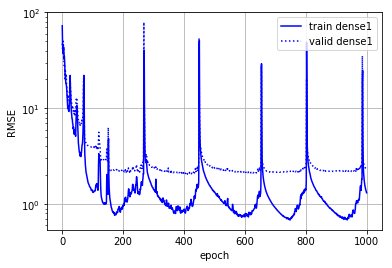

In [19]:
plot_loss([model1_hist],['dense1'])

In [20]:
model1BN = Sequential()
model1BN.add(Flatten(input_shape=INPUT_SHAPE))
model1BN.add(Dense(100, activation='relu'))
model1BN.add(BatchNormalization())
model1BN.add(Dense(30))
print(model1BN.summary())
model1BN_hist, model1BN = fit_model(model1BN,data,
                                    '1dense100neuronlayer_wbatchnormalization')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 100)               921700    
_________________________________________________________________
batch_normalization_11 (Batc (None, 100)               400       
_________________________________________________________________
dense_10 (Dense)             (None, 30)                3030      
Total params: 925,130
Trainable params: 924,930
Non-trainable params: 200
_________________________________________________________________
None


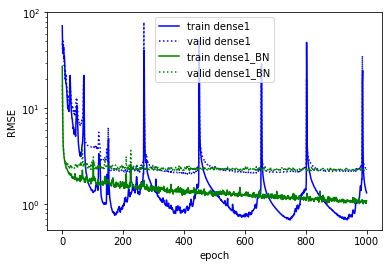

In [21]:
plot_loss([model1_hist,model1BN_hist],['dense1','dense1_BN'])

### Model with convolutions

In [22]:
model2 = Sequential()
model2.add(Conv2D(32,
                 (3, 3),
                 activation='relu',
                input_shape=INPUT_SHAPE))
model2.add(BatchNormalization())
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Conv2D(filters=64,
                 kernel_size=(2, 2),
                 activation='relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Conv2D(filters=128,
                 kernel_size=(2, 2),
                 activation='relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Flatten())
model2.add(Dense(500, activation = "relu"))
model2.add(BatchNormalization())
model2.add(Dense(100, activation = "relu"))
model2.add(BatchNormalization())
model2.add(Dense(30))
print(model2.summary())

model2_hist, model2 = fit_model(model2,data,
                                    'CNN')


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 94, 94, 32)        320       
_________________________________________________________________
batch_normalization_12 (Batc (None, 94, 94, 32)        128       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 47, 47, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 46, 46, 64)        8256      
_________________________________________________________________
batch_normalization_13 (Batc (None, 46, 46, 64)        256       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 22, 22, 128)       32896     
__________

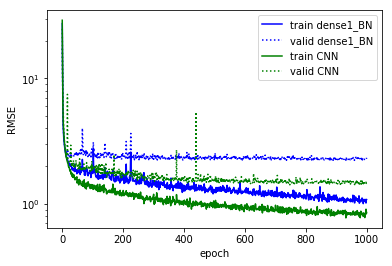

In [23]:
plot_loss([model1BN_hist, model2_hist],['dense1_BN','CNN'])

### Use the custom generator to enhance the training data

In [65]:
datagen = CustImageDataGenerator(
    rotation_range=5. #degrees
     ,horizontal_flip=True
     ,width_shift_range=.05 # percent of image width
     ,height_shift_range=.05 # percent of image height
    ).flow(X_train,y_train,whichlabels=list(labels), batch_size=32)

In [66]:
# basically a copy of model 2, but will train with augmented data
model2_augmented = Sequential()
model2_augmented.add(Conv2D(32,
                 (3, 3),
                 activation='relu',
                input_shape=INPUT_SHAPE))
model2_augmented.add(BatchNormalization())
model2_augmented.add(MaxPooling2D(pool_size=(2, 2)))
model2_augmented.add(Conv2D(filters=64,
                 kernel_size=(2, 2),
                 activation='relu'))
model2_augmented.add(BatchNormalization())
model2_augmented.add(MaxPooling2D(pool_size=(2, 2)))
model2_augmented.add(Conv2D(filters=128,
                 kernel_size=(2, 2),
                 activation='relu'))
model2_augmented.add(BatchNormalization())
model2_augmented.add(MaxPooling2D(pool_size=(2, 2)))
model2_augmented.add(Flatten())
model2_augmented.add(Dense(500, activation = "relu"))
model2_augmented.add(BatchNormalization())
model2_augmented.add(Dense(100, activation = "relu"))
model2_augmented.add(BatchNormalization())
model2_augmented.add(Dense(30))
print(model2_augmented.summary())
model2_augmented_hist, model2_augmented = fit_model(model2_augmented, data,
                                                    'CNN_augmented',datagen)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 94, 94, 32)        320       
_________________________________________________________________
batch_normalization_7 (Batch (None, 94, 94, 32)        128       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 47, 47, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 46, 46, 64)        8256      
_________________________________________________________________
batch_normalization_8 (Batch (None, 46, 46, 64)        256       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 22, 22, 128)       32896     
__________

53/53 [==============================] - 3s 54ms/step - loss: 0.0017 - val_loss: 0.0012
Epoch 139/1000
53/53 [==============================] - 3s 55ms/step - loss: 0.0015 - val_loss: 0.0012
Epoch 140/1000
53/53 [==============================] - 3s 55ms/step - loss: 0.0018 - val_loss: 0.0013
Epoch 141/1000
53/53 [==============================] - 3s 54ms/step - loss: 0.0016 - val_loss: 0.0012
Epoch 142/1000
53/53 [==============================] - 3s 54ms/step - loss: 0.0018 - val_loss: 0.0020
Epoch 143/1000
53/53 [==============================] - 3s 55ms/step - loss: 0.0017 - val_loss: 0.0021
Epoch 144/1000
53/53 [==============================] - 3s 54ms/step - loss: 0.0017 - val_loss: 0.0017
Epoch 145/1000
53/53 [==============================] - 3s 54ms/step - loss: 0.0015 - val_loss: 0.0012
Epoch 146/1000
53/53 [==============================] - 3s 55ms/step - loss: 0.0017 - val_loss: 0.0013
Epoch 147/1000
53/53 [==============================] - 3s 54ms/step - loss: 0.0016 - va

53/53 [==============================] - 3s 54ms/step - loss: 0.0011 - val_loss: 0.0017
Epoch 297/1000
53/53 [==============================] - 3s 54ms/step - loss: 0.0011 - val_loss: 0.0013
Epoch 298/1000
53/53 [==============================] - 3s 54ms/step - loss: 0.0012 - val_loss: 9.9887e-04
Epoch 299/1000
53/53 [==============================] - 3s 55ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 300/1000
53/53 [==============================] - 3s 55ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 301/1000
53/53 [==============================] - 3s 54ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 302/1000
53/53 [==============================] - 3s 54ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 303/1000
53/53 [==============================] - 3s 54ms/step - loss: 0.0011 - val_loss: 0.0013
Epoch 304/1000
53/53 [==============================] - 3s 55ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 305/1000
53/53 [==============================] - 3s 54ms/step - loss: 0.0011 

Epoch 375/1000
53/53 [==============================] - 3s 54ms/step - loss: 0.0011 - val_loss: 8.6381e-04
Epoch 376/1000
53/53 [==============================] - 3s 54ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 377/1000
53/53 [==============================] - 3s 54ms/step - loss: 0.0010 - val_loss: 9.5350e-04
Epoch 378/1000
53/53 [==============================] - 3s 54ms/step - loss: 9.2062e-04 - val_loss: 0.0011
Epoch 379/1000
53/53 [==============================] - 3s 54ms/step - loss: 9.1606e-04 - val_loss: 0.0014
Epoch 380/1000
53/53 [==============================] - 3s 54ms/step - loss: 9.9769e-04 - val_loss: 0.0014
Epoch 381/1000
53/53 [==============================] - 3s 54ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 382/1000
53/53 [==============================] - 3s 54ms/step - loss: 9.8521e-04 - val_loss: 0.0011
Epoch 383/1000
53/53 [==============================] - 3s 55ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 384/1000
53/53 [===========================

53/53 [==============================] - 3s 54ms/step - loss: 9.2526e-04 - val_loss: 0.0013
Epoch 529/1000
53/53 [==============================] - 3s 54ms/step - loss: 9.2471e-04 - val_loss: 0.0017
Epoch 530/1000
53/53 [==============================] - 3s 55ms/step - loss: 9.2336e-04 - val_loss: 0.0011
Epoch 531/1000
53/53 [==============================] - 3s 54ms/step - loss: 8.9442e-04 - val_loss: 9.7759e-04
Epoch 532/1000
53/53 [==============================] - 3s 55ms/step - loss: 9.8741e-04 - val_loss: 9.9224e-04
Epoch 533/1000
53/53 [==============================] - 3s 55ms/step - loss: 8.8529e-04 - val_loss: 0.0013
Epoch 534/1000
53/53 [==============================] - 3s 54ms/step - loss: 9.3121e-04 - val_loss: 0.0013
Epoch 535/1000
53/53 [==============================] - 3s 54ms/step - loss: 7.6652e-04 - val_loss: 0.0014
Epoch 536/1000
53/53 [==============================] - 3s 54ms/step - loss: 9.7153e-04 - val_loss: 0.0014
Epoch 537/1000
53/53 [======================

53/53 [==============================] - 3s 55ms/step - loss: 7.4897e-04 - val_loss: 0.0010
Epoch 679/1000
53/53 [==============================] - 3s 55ms/step - loss: 8.8143e-04 - val_loss: 0.0011
Epoch 680/1000
53/53 [==============================] - 3s 54ms/step - loss: 8.2107e-04 - val_loss: 8.6687e-04
Epoch 681/1000
53/53 [==============================] - 3s 55ms/step - loss: 7.0811e-04 - val_loss: 8.7092e-04
Epoch 682/1000
53/53 [==============================] - 3s 54ms/step - loss: 7.6341e-04 - val_loss: 9.8706e-04
Epoch 683/1000
53/53 [==============================] - 3s 54ms/step - loss: 7.7158e-04 - val_loss: 9.0526e-04
Epoch 684/1000
53/53 [==============================] - 3s 55ms/step - loss: 7.4568e-04 - val_loss: 8.0654e-04
Epoch 685/1000
53/53 [==============================] - 3s 55ms/step - loss: 7.2706e-04 - val_loss: 0.0010
Epoch 686/1000
53/53 [==============================] - 3s 54ms/step - loss: 8.1336e-04 - val_loss: 8.8335e-04
Epoch 687/1000
53/53 [======

Epoch 753/1000
53/53 [==============================] - 3s 54ms/step - loss: 7.2357e-04 - val_loss: 9.1398e-04
Epoch 754/1000
53/53 [==============================] - 3s 54ms/step - loss: 6.9023e-04 - val_loss: 8.9924e-04
Epoch 755/1000
53/53 [==============================] - 3s 54ms/step - loss: 8.5552e-04 - val_loss: 9.7483e-04
Epoch 756/1000
53/53 [==============================] - 3s 54ms/step - loss: 6.9586e-04 - val_loss: 7.9363e-04
Epoch 757/1000
53/53 [==============================] - 3s 54ms/step - loss: 6.7695e-04 - val_loss: 9.6635e-04
Epoch 758/1000
53/53 [==============================] - 3s 55ms/step - loss: 6.8936e-04 - val_loss: 9.0841e-04
Epoch 759/1000
53/53 [==============================] - 3s 56ms/step - loss: 7.3308e-04 - val_loss: 9.2128e-04
Epoch 760/1000
53/53 [==============================] - 3s 54ms/step - loss: 8.1637e-04 - val_loss: 0.0012
Epoch 761/1000
53/53 [==============================] - 3s 55ms/step - loss: 7.0879e-04 - val_loss: 8.0733e-04
Epoch

53/53 [==============================] - 3s 54ms/step - loss: 6.7695e-04 - val_loss: 8.1793e-04
Epoch 828/1000
53/53 [==============================] - 3s 55ms/step - loss: 6.5915e-04 - val_loss: 9.3645e-04
Epoch 829/1000
53/53 [==============================] - 3s 54ms/step - loss: 6.8129e-04 - val_loss: 8.6431e-04
Epoch 830/1000
53/53 [==============================] - 3s 54ms/step - loss: 7.0157e-04 - val_loss: 9.9326e-04
Epoch 831/1000
53/53 [==============================] - 3s 54ms/step - loss: 6.7840e-04 - val_loss: 0.0011
Epoch 832/1000
53/53 [==============================] - 3s 54ms/step - loss: 6.5208e-04 - val_loss: 0.0010
Epoch 833/1000
53/53 [==============================] - 3s 55ms/step - loss: 7.0949e-04 - val_loss: 8.3138e-04
Epoch 834/1000
53/53 [==============================] - 3s 54ms/step - loss: 6.9638e-04 - val_loss: 8.4315e-04
Epoch 835/1000
53/53 [==============================] - 3s 55ms/step - loss: 6.4599e-04 - val_loss: 8.2979e-04
Epoch 836/1000
53/53 [==

53/53 [==============================] - 3s 54ms/step - loss: 7.6079e-04 - val_loss: 0.0011
Epoch 976/1000
53/53 [==============================] - 3s 54ms/step - loss: 6.2200e-04 - val_loss: 7.7015e-04
Epoch 977/1000
53/53 [==============================] - 3s 54ms/step - loss: 5.8156e-04 - val_loss: 7.7377e-04
Epoch 978/1000
53/53 [==============================] - 3s 56ms/step - loss: 5.8741e-04 - val_loss: 7.5202e-04
Epoch 979/1000
53/53 [==============================] - 3s 54ms/step - loss: 6.2293e-04 - val_loss: 9.2670e-04
Epoch 980/1000
53/53 [==============================] - 3s 54ms/step - loss: 6.5197e-04 - val_loss: 7.6357e-04
Epoch 981/1000
53/53 [==============================] - 3s 54ms/step - loss: 6.1995e-04 - val_loss: 8.0949e-04
Epoch 982/1000
53/53 [==============================] - 3s 55ms/step - loss: 5.5552e-04 - val_loss: 7.4897e-04
Epoch 983/1000
53/53 [==============================] - 3s 54ms/step - loss: 6.0538e-04 - val_loss: 8.7088e-04
Epoch 984/1000
53/53

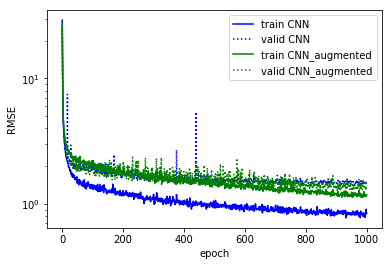

In [67]:
plot_loss([model2_hist, model2_augmented_hist],['CNN','CNN_augmented'])

The augmented data improves the validation RMSE by adding some variance to the training data.

### Add Dropout to avoid over-fitting and up the last hidden level

In [68]:
model3 = Sequential()
model3.add(Conv2D(32,
                 (3, 3),
                 activation='relu',
                input_shape=INPUT_SHAPE))
model3.add(BatchNormalization())
model3.add(MaxPooling2D(pool_size=(2, 2)))
model3.add(Dropout(.1))
model3.add(Conv2D(filters=64,
                 kernel_size=(2, 2),
                 activation='relu'))
model3.add(BatchNormalization())
model3.add(MaxPooling2D(pool_size=(2, 2)))
model3.add(Dropout(.2))
model3.add(Conv2D(filters=128,
                 kernel_size=(2, 2),
                 activation='relu'))
model3.add(BatchNormalization())
model3.add(MaxPooling2D(pool_size=(2, 2)))
model3.add(Dropout(.3))
model3.add(Flatten())
model3.add(Dense(500, activation = "relu"))
model3.add(Dropout(.5))
model3.add(BatchNormalization())
model3.add(Dense(500, activation = "relu"))
model3.add(BatchNormalization())
model3.add(Dense(30))
print(model3.summary())
model3_hist, model3 = fit_model(model3, data,
                                'CNN_aug_dropout',datagen,
                                patience=1000)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 94, 94, 32)        320       
_________________________________________________________________
batch_normalization_12 (Batc (None, 94, 94, 32)        128       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 47, 47, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 47, 47, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 46, 46, 64)        8256      
_________________________________________________________________
batch_normalization_13 (Batc (None, 46, 46, 64)        256       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 23, 23, 64)        0         
__________

53/53 [==============================] - 3s 59ms/step - loss: 0.0040 - val_loss: 0.0023
Epoch 134/1000
53/53 [==============================] - 3s 59ms/step - loss: 0.0041 - val_loss: 0.0028
Epoch 135/1000
53/53 [==============================] - 3s 59ms/step - loss: 0.0041 - val_loss: 0.0032
Epoch 136/1000
53/53 [==============================] - 3s 59ms/step - loss: 0.0044 - val_loss: 0.0047
Epoch 137/1000
53/53 [==============================] - 3s 59ms/step - loss: 0.0044 - val_loss: 0.0051
Epoch 138/1000
53/53 [==============================] - 3s 59ms/step - loss: 0.0041 - val_loss: 0.0070
Epoch 139/1000
53/53 [==============================] - 3s 58ms/step - loss: 0.0040 - val_loss: 0.0017
Epoch 140/1000
53/53 [==============================] - 3s 59ms/step - loss: 0.0039 - val_loss: 0.0027
Epoch 141/1000
53/53 [==============================] - 3s 59ms/step - loss: 0.0041 - val_loss: 0.0020
Epoch 142/1000
53/53 [==============================] - 3s 59ms/step - loss: 0.0044 - va

53/53 [==============================] - 3s 58ms/step - loss: 0.0025 - val_loss: 0.0019
Epoch 292/1000
53/53 [==============================] - 3s 59ms/step - loss: 0.0024 - val_loss: 0.0016
Epoch 293/1000
53/53 [==============================] - 3s 59ms/step - loss: 0.0024 - val_loss: 0.0014
Epoch 294/1000
53/53 [==============================] - 3s 59ms/step - loss: 0.0026 - val_loss: 0.0015
Epoch 295/1000
53/53 [==============================] - 3s 58ms/step - loss: 0.0025 - val_loss: 0.0042
Epoch 296/1000
53/53 [==============================] - 3s 59ms/step - loss: 0.0025 - val_loss: 0.0015
Epoch 297/1000
53/53 [==============================] - 3s 59ms/step - loss: 0.0025 - val_loss: 0.0036
Epoch 298/1000
53/53 [==============================] - 3s 59ms/step - loss: 0.0025 - val_loss: 0.0024
Epoch 299/1000
53/53 [==============================] - 3s 58ms/step - loss: 0.0024 - val_loss: 0.0022
Epoch 300/1000
53/53 [==============================] - 3s 59ms/step - loss: 0.0024 - va

53/53 [==============================] - 3s 59ms/step - loss: 0.0018 - val_loss: 0.0013
Epoch 450/1000
53/53 [==============================] - 3s 59ms/step - loss: 0.0018 - val_loss: 0.0013
Epoch 451/1000
53/53 [==============================] - 3s 59ms/step - loss: 0.0018 - val_loss: 0.0012
Epoch 452/1000
53/53 [==============================] - 3s 58ms/step - loss: 0.0019 - val_loss: 0.0011
Epoch 453/1000
53/53 [==============================] - 3s 59ms/step - loss: 0.0018 - val_loss: 0.0012
Epoch 454/1000
53/53 [==============================] - 3s 58ms/step - loss: 0.0018 - val_loss: 0.0010
Epoch 455/1000
53/53 [==============================] - 3s 59ms/step - loss: 0.0018 - val_loss: 0.0013
Epoch 456/1000
53/53 [==============================] - 3s 59ms/step - loss: 0.0018 - val_loss: 0.0013
Epoch 457/1000
53/53 [==============================] - 3s 58ms/step - loss: 0.0018 - val_loss: 0.0194
Epoch 458/1000
53/53 [==============================] - 3s 59ms/step - loss: 0.0021 - va

53/53 [==============================] - 3s 59ms/step - loss: 0.0016 - val_loss: 0.0014
Epoch 607/1000
53/53 [==============================] - 3s 59ms/step - loss: 0.0015 - val_loss: 0.0011
Epoch 608/1000
53/53 [==============================] - 3s 59ms/step - loss: 0.0014 - val_loss: 9.4704e-04
Epoch 609/1000
53/53 [==============================] - 3s 59ms/step - loss: 0.0014 - val_loss: 9.5934e-04
Epoch 610/1000
53/53 [==============================] - 3s 58ms/step - loss: 0.0014 - val_loss: 8.8990e-04
Epoch 611/1000
53/53 [==============================] - 3s 59ms/step - loss: 0.0014 - val_loss: 0.0011
Epoch 612/1000
53/53 [==============================] - 3s 59ms/step - loss: 0.0014 - val_loss: 9.1289e-04
Epoch 613/1000
53/53 [==============================] - 3s 58ms/step - loss: 0.0015 - val_loss: 8.7682e-04
Epoch 614/1000
53/53 [==============================] - 3s 59ms/step - loss: 0.0014 - val_loss: 7.9086e-04
Epoch 615/1000
53/53 [==============================] - 3s 59ms/

53/53 [==============================] - 3s 57ms/step - loss: 0.0013 - val_loss: 7.6042e-04
Epoch 684/1000
53/53 [==============================] - 3s 59ms/step - loss: 0.0014 - val_loss: 7.6208e-04
Epoch 685/1000
53/53 [==============================] - 3s 58ms/step - loss: 0.0013 - val_loss: 8.3359e-04
Epoch 686/1000
53/53 [==============================] - 3s 57ms/step - loss: 0.0013 - val_loss: 8.4489e-04
Epoch 687/1000
53/53 [==============================] - 3s 58ms/step - loss: 0.0013 - val_loss: 8.2642e-04
Epoch 688/1000
53/53 [==============================] - 3s 59ms/step - loss: 0.0013 - val_loss: 8.7530e-04
Epoch 689/1000
53/53 [==============================] - 3s 59ms/step - loss: 0.0013 - val_loss: 8.0578e-04
Epoch 690/1000
53/53 [==============================] - 3s 59ms/step - loss: 0.0013 - val_loss: 7.9195e-04
Epoch 691/1000
53/53 [==============================] - 3s 59ms/step - loss: 0.0013 - val_loss: 8.3796e-04
Epoch 692/1000
53/53 [==============================

Epoch 760/1000
53/53 [==============================] - 3s 59ms/step - loss: 0.0012 - val_loss: 7.1384e-04
Epoch 761/1000
53/53 [==============================] - 3s 59ms/step - loss: 0.0012 - val_loss: 6.8891e-04
Epoch 762/1000
53/53 [==============================] - 3s 58ms/step - loss: 0.0012 - val_loss: 6.4575e-04
Epoch 763/1000
53/53 [==============================] - 3s 59ms/step - loss: 0.0012 - val_loss: 8.4704e-04
Epoch 764/1000
53/53 [==============================] - 3s 59ms/step - loss: 0.0012 - val_loss: 6.8179e-04
Epoch 765/1000
53/53 [==============================] - 3s 59ms/step - loss: 0.0011 - val_loss: 7.4254e-04
Epoch 766/1000
53/53 [==============================] - 3s 59ms/step - loss: 0.0012 - val_loss: 6.6565e-04
Epoch 767/1000
53/53 [==============================] - 3s 59ms/step - loss: 0.0012 - val_loss: 6.8090e-04
Epoch 768/1000
53/53 [==============================] - 3s 59ms/step - loss: 0.0012 - val_loss: 7.0452e-04
Epoch 769/1000
53/53 [===============

Epoch 913/1000
53/53 [==============================] - 3s 57ms/step - loss: 0.0011 - val_loss: 6.2586e-04
Epoch 914/1000
53/53 [==============================] - 3s 58ms/step - loss: 0.0010 - val_loss: 6.4883e-04
Epoch 915/1000
53/53 [==============================] - 3s 59ms/step - loss: 0.0010 - val_loss: 5.8912e-04
Epoch 916/1000
53/53 [==============================] - 3s 59ms/step - loss: 0.0011 - val_loss: 5.9350e-04
Epoch 917/1000
53/53 [==============================] - 3s 57ms/step - loss: 0.0011 - val_loss: 5.8468e-04
Epoch 918/1000
53/53 [==============================] - 3s 57ms/step - loss: 0.0011 - val_loss: 5.9076e-04
Epoch 919/1000
53/53 [==============================] - 3s 57ms/step - loss: 0.0010 - val_loss: 5.9961e-04
Epoch 920/1000
53/53 [==============================] - 3s 59ms/step - loss: 0.0011 - val_loss: 5.9693e-04
Epoch 921/1000
53/53 [==============================] - 3s 59ms/step - loss: 0.0010 - val_loss: 6.2358e-04
Epoch 922/1000
53/53 [===============

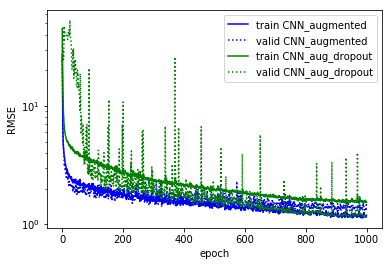

In [69]:
plot_loss([model2_augmented_hist, model3_hist],['CNN_augmented','CNN_aug_dropout'])

switch the BN to be before the dropout .5 and test reducing the level of dropout

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 94, 94, 32)        320       
_________________________________________________________________
batch_normalization_17 (Batc (None, 94, 94, 32)        128       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 47, 47, 32)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 47, 47, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 46, 46, 64)        8256      
_________________________________________________________________
batch_normalization_18 (Batc (None, 46, 46, 64)        256       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 23, 23, 64)        0         
__________

53/53 [==============================] - 3s 58ms/step - loss: 0.0033 - val_loss: 0.0025
Epoch 134/1000
53/53 [==============================] - 3s 58ms/step - loss: 0.0035 - val_loss: 0.0024
Epoch 135/1000
53/53 [==============================] - 3s 58ms/step - loss: 0.0031 - val_loss: 0.0024
Epoch 136/1000
53/53 [==============================] - 3s 58ms/step - loss: 0.0035 - val_loss: 0.0028
Epoch 137/1000
53/53 [==============================] - 3s 59ms/step - loss: 0.0034 - val_loss: 0.0030
Epoch 138/1000
53/53 [==============================] - 3s 58ms/step - loss: 0.0033 - val_loss: 0.0018
Epoch 139/1000
53/53 [==============================] - 3s 58ms/step - loss: 0.0033 - val_loss: 0.0027
Epoch 140/1000
53/53 [==============================] - 3s 58ms/step - loss: 0.0035 - val_loss: 0.0018
Epoch 141/1000
53/53 [==============================] - 3s 58ms/step - loss: 0.0034 - val_loss: 0.0026
Epoch 142/1000
53/53 [==============================] - 3s 59ms/step - loss: 0.0036 - va

53/53 [==============================] - 3s 58ms/step - loss: 0.0024 - val_loss: 0.0012
Epoch 292/1000
53/53 [==============================] - 3s 58ms/step - loss: 0.0023 - val_loss: 0.0035
Epoch 293/1000
53/53 [==============================] - 3s 59ms/step - loss: 0.0022 - val_loss: 0.0029
Epoch 294/1000
53/53 [==============================] - 3s 59ms/step - loss: 0.0022 - val_loss: 0.0015
Epoch 295/1000
53/53 [==============================] - 3s 59ms/step - loss: 0.0022 - val_loss: 0.0121
Epoch 296/1000
53/53 [==============================] - 3s 59ms/step - loss: 0.0021 - val_loss: 0.0219
Epoch 297/1000
53/53 [==============================] - 3s 58ms/step - loss: 0.0034 - val_loss: 0.0037
Epoch 298/1000
53/53 [==============================] - 3s 59ms/step - loss: 0.0026 - val_loss: 0.0015
Epoch 299/1000
53/53 [==============================] - 3s 58ms/step - loss: 0.0023 - val_loss: 0.0015
Epoch 300/1000
53/53 [==============================] - 3s 59ms/step - loss: 0.0022 - va

Epoch 449/1000
53/53 [==============================] - 3s 57ms/step - loss: 0.0017 - val_loss: 9.4946e-04
Epoch 450/1000
53/53 [==============================] - 3s 59ms/step - loss: 0.0016 - val_loss: 9.1371e-04
Epoch 451/1000
53/53 [==============================] - 3s 58ms/step - loss: 0.0018 - val_loss: 0.0016
Epoch 452/1000
53/53 [==============================] - 3s 59ms/step - loss: 0.0017 - val_loss: 0.0012
Epoch 453/1000
53/53 [==============================] - 3s 58ms/step - loss: 0.0019 - val_loss: 0.0012
Epoch 454/1000
53/53 [==============================] - 3s 58ms/step - loss: 0.0017 - val_loss: 0.0013
Epoch 455/1000
53/53 [==============================] - 3s 59ms/step - loss: 0.0016 - val_loss: 0.0011
Epoch 456/1000
53/53 [==============================] - 3s 58ms/step - loss: 0.0017 - val_loss: 0.0010
Epoch 457/1000
53/53 [==============================] - 3s 59ms/step - loss: 0.0017 - val_loss: 0.0011
Epoch 458/1000
53/53 [==============================] - 3s 59ms/s

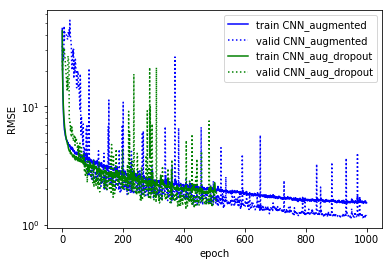

In [70]:
model3_2 = Sequential()
model3_2.add(Conv2D(32,
                 (3, 3),
                 activation='relu',
                input_shape=INPUT_SHAPE))
model3_2.add(BatchNormalization())
model3_2.add(MaxPooling2D(pool_size=(2, 2)))
model3_2.add(Dropout(.1))
model3_2.add(Conv2D(filters=64,
                 kernel_size=(2, 2),
                 activation='relu'))
model3_2.add(BatchNormalization())
model3_2.add(MaxPooling2D(pool_size=(2, 2)))
model3_2.add(Dropout(.2))
model3_2.add(Conv2D(filters=128,
                 kernel_size=(2, 2),
                 activation='relu'))
model3_2.add(BatchNormalization())
model3_2.add(MaxPooling2D(pool_size=(2, 2)))
model3_2.add(Dropout(.3))
model3_2.add(Flatten())
model3_2.add(Dense(500, activation = "relu"))
model3_2.add(BatchNormalization())
model3_2.add(Dropout(.5))
model3_2.add(Dense(500, activation = "relu"))
model3_2.add(BatchNormalization())
model3_2.add(Dense(30))
print(model3_2.summary())
model3_2_hist, model3_2 = fit_model(model3_2, data,
                                'CNN_aug_dropout_2',datagen,
                                patience=100)
plot_loss([model3_hist, model3_2_hist],['CNN_augmented','CNN_aug_dropout','CNN_aug_dropout2'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 94, 94, 32)        320       
_________________________________________________________________
batch_normalization_22 (Batc (None, 94, 94, 32)        128       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 47, 47, 32)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 47, 47, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 46, 46, 64)        8256      
_________________________________________________________________
batch_normalization_23 (Batc (None, 46, 46, 64)        256       
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 23, 23, 64)        0         
__________

53/53 [==============================] - 3s 57ms/step - loss: 0.0041 - val_loss: 0.0043
Epoch 134/1000
53/53 [==============================] - 3s 58ms/step - loss: 0.0037 - val_loss: 0.0032
Epoch 135/1000
53/53 [==============================] - 3s 58ms/step - loss: 0.0036 - val_loss: 0.0025
Epoch 136/1000
53/53 [==============================] - 3s 58ms/step - loss: 0.0032 - val_loss: 0.0024
Epoch 137/1000
53/53 [==============================] - 3s 58ms/step - loss: 0.0030 - val_loss: 0.0022
Epoch 138/1000
53/53 [==============================] - 3s 58ms/step - loss: 0.0034 - val_loss: 0.0035
Epoch 139/1000
53/53 [==============================] - 3s 58ms/step - loss: 0.0035 - val_loss: 0.0033
Epoch 140/1000
53/53 [==============================] - 3s 57ms/step - loss: 0.0031 - val_loss: 0.0017
Epoch 141/1000
53/53 [==============================] - 3s 58ms/step - loss: 0.0036 - val_loss: 0.0020
Epoch 142/1000
53/53 [==============================] - 3s 58ms/step - loss: 0.0033 - va

53/53 [==============================] - 3s 58ms/step - loss: 0.0022 - val_loss: 0.0014
Epoch 292/1000
53/53 [==============================] - 3s 58ms/step - loss: 0.0022 - val_loss: 0.0011
Epoch 293/1000
53/53 [==============================] - 3s 56ms/step - loss: 0.0023 - val_loss: 0.0014
Epoch 294/1000
53/53 [==============================] - 3s 58ms/step - loss: 0.0019 - val_loss: 0.0013
Epoch 295/1000
53/53 [==============================] - 3s 58ms/step - loss: 0.0024 - val_loss: 0.0428
Epoch 296/1000
53/53 [==============================] - 3s 58ms/step - loss: 0.0039 - val_loss: 0.0129
Epoch 297/1000
53/53 [==============================] - 3s 59ms/step - loss: 0.0034 - val_loss: 0.0074
Epoch 298/1000
53/53 [==============================] - 3s 58ms/step - loss: 0.0034 - val_loss: 0.0039
Epoch 299/1000
53/53 [==============================] - 3s 58ms/step - loss: 0.0027 - val_loss: 0.0018
Epoch 300/1000
53/53 [==============================] - 3s 56ms/step - loss: 0.0027 - va

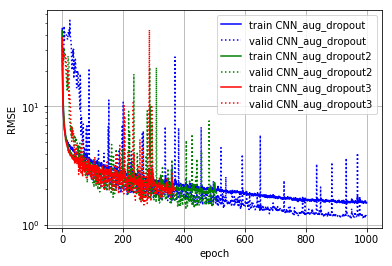

In [71]:
model3_3 = Sequential()
model3_3.add(Conv2D(32,
                 (3, 3),
                 activation='relu',
                input_shape=INPUT_SHAPE))
model3_3.add(BatchNormalization())
model3_3.add(MaxPooling2D(pool_size=(2, 2)))
model3_3.add(Dropout(.1))
model3_3.add(Conv2D(filters=64,
                 kernel_size=(2, 2),
                 activation='relu'))
model3_3.add(BatchNormalization())
model3_3.add(MaxPooling2D(pool_size=(2, 2)))
model3_3.add(Dropout(.2))
model3_3.add(Conv2D(filters=128,
                 kernel_size=(2, 2),
                 activation='relu'))
model3_3.add(BatchNormalization())
model3_3.add(MaxPooling2D(pool_size=(2, 2)))
model3_3.add(Dropout(.3))
model3_3.add(Flatten())
model3_3.add(Dense(500, activation = "relu"))
model3_3.add(BatchNormalization())
model3_3.add(Dropout(.3))
model3_3.add(Dense(500, activation = "relu"))
model3_3.add(BatchNormalization())
model3_3.add(Dense(30))
print(model3_3.summary())
model3_3_hist, model3_3 = fit_model(model3_3, data,
                                'CNN_aug_dropout_3',datagen,
                                patience=100)
plot_loss([model3_hist, model3_2_hist, model3_3_hist],
          ['CNN_aug_dropout','CNN_aug_dropout2','CNN_aug_dropout3'])

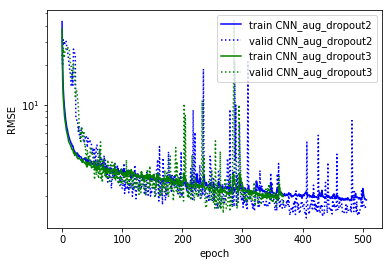

In [72]:
plot_loss([model3_2_hist, model3_3_hist],
          ['CNN_aug_dropout2','CNN_aug_dropout3'])

### What if only dropout after batch normalization layers

In [73]:
model3_4 = Sequential()
model3_4.add(Conv2D(32,
                 (3, 3),
                 activation='relu',
                input_shape=INPUT_SHAPE))
model3_4.add(BatchNormalization())
model3_4.add(MaxPooling2D(pool_size=(2, 2)))
model3_4.add(Conv2D(filters=64,
                 kernel_size=(2, 2),
                 activation='relu'))
model3_4.add(BatchNormalization())
model3_4.add(MaxPooling2D(pool_size=(2, 2)))
model3_4.add(Conv2D(filters=128,
                 kernel_size=(2, 2),
                 activation='relu'))
model3_4.add(BatchNormalization())
model3_4.add(MaxPooling2D(pool_size=(2, 2)))
model3_4.add(Flatten())
model3_4.add(Dense(500, activation = "relu"))
model3_4.add(BatchNormalization())
model3_4.add(Dense(500, activation = "relu"))
model3_4.add(BatchNormalization())
model3_4.add(Dropout(.3))
model3_4.add(Dense(30))
print(model3_4.summary())
model3_4_hist, model3_4 = fit_model(model3_4, data,
                                'CNN_aug_dropout_4',datagen,
                                patience=100)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 94, 94, 32)        320       
_________________________________________________________________
batch_normalization_27 (Batc (None, 94, 94, 32)        128       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 47, 47, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 46, 46, 64)        8256      
_________________________________________________________________
batch_normalization_28 (Batc (None, 46, 46, 64)        256       
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 22, 22, 128)       32896     
__________

53/53 [==============================] - 3s 54ms/step - loss: 0.0025 - val_loss: 0.0018
Epoch 138/1000
53/53 [==============================] - 3s 54ms/step - loss: 0.0024 - val_loss: 0.0035
Epoch 139/1000
53/53 [==============================] - 3s 54ms/step - loss: 0.0025 - val_loss: 0.0014
Epoch 140/1000
53/53 [==============================] - 3s 54ms/step - loss: 0.0023 - val_loss: 0.0014
Epoch 141/1000
53/53 [==============================] - 3s 55ms/step - loss: 0.0022 - val_loss: 0.0015
Epoch 142/1000
53/53 [==============================] - 3s 54ms/step - loss: 0.0024 - val_loss: 0.0017
Epoch 143/1000
53/53 [==============================] - 3s 54ms/step - loss: 0.0022 - val_loss: 0.0015
Epoch 144/1000
53/53 [==============================] - 3s 55ms/step - loss: 0.0023 - val_loss: 0.0013
Epoch 145/1000
53/53 [==============================] - 3s 55ms/step - loss: 0.0022 - val_loss: 0.0015
Epoch 146/1000
53/53 [==============================] - 3s 54ms/step - loss: 0.0021 - va

53/53 [==============================] - 3s 55ms/step - loss: 9.3430e-04 - val_loss: 7.1867e-04
Epoch 216/1000
53/53 [==============================] - 3s 55ms/step - loss: 9.1577e-04 - val_loss: 7.0151e-04
Epoch 217/1000
53/53 [==============================] - 3s 54ms/step - loss: 9.2756e-04 - val_loss: 6.7579e-04
Epoch 218/1000
53/53 [==============================] - 3s 55ms/step - loss: 9.7968e-04 - val_loss: 7.4043e-04
Epoch 219/1000
53/53 [==============================] - 3s 54ms/step - loss: 9.3511e-04 - val_loss: 7.8106e-04
Epoch 220/1000
53/53 [==============================] - 3s 54ms/step - loss: 0.0010 - val_loss: 7.2406e-04
Epoch 221/1000
53/53 [==============================] - 3s 54ms/step - loss: 9.0688e-04 - val_loss: 6.7576e-04
Epoch 222/1000
53/53 [==============================] - 3s 55ms/step - loss: 9.8083e-04 - val_loss: 7.0890e-04
Epoch 223/1000
53/53 [==============================] - 3s 54ms/step - loss: 8.8259e-04 - val_loss: 6.7232e-04
Epoch 224/1000
53/53

Epoch 289/1000
53/53 [==============================] - 3s 54ms/step - loss: 8.0897e-04 - val_loss: 6.3330e-04
Epoch 290/1000
53/53 [==============================] - 3s 54ms/step - loss: 7.4929e-04 - val_loss: 6.2393e-04
Epoch 291/1000
53/53 [==============================] - 3s 53ms/step - loss: 7.8514e-04 - val_loss: 6.2958e-04
Epoch 292/1000
53/53 [==============================] - 3s 54ms/step - loss: 8.1670e-04 - val_loss: 6.3067e-04
Epoch 293/1000
53/53 [==============================] - 3s 54ms/step - loss: 7.6832e-04 - val_loss: 6.4440e-04
Epoch 294/1000
53/53 [==============================] - 3s 54ms/step - loss: 7.4808e-04 - val_loss: 6.3149e-04
Epoch 295/1000
53/53 [==============================] - 3s 54ms/step - loss: 7.2046e-04 - val_loss: 6.5007e-04
Epoch 296/1000
53/53 [==============================] - 3s 55ms/step - loss: 7.7091e-04 - val_loss: 6.7095e-04
Epoch 297/1000
53/53 [==============================] - 3s 54ms/step - loss: 8.4930e-04 - val_loss: 6.4694e-04
E

Epoch 363/1000
53/53 [==============================] - 3s 55ms/step - loss: 7.1639e-04 - val_loss: 6.1326e-04
Epoch 364/1000
53/53 [==============================] - 3s 54ms/step - loss: 7.1345e-04 - val_loss: 6.1159e-04
Epoch 365/1000
53/53 [==============================] - 3s 54ms/step - loss: 7.0290e-04 - val_loss: 6.0886e-04
Epoch 366/1000
53/53 [==============================] - 3s 54ms/step - loss: 7.2530e-04 - val_loss: 6.2080e-04
Epoch 367/1000
53/53 [==============================] - 3s 54ms/step - loss: 6.9468e-04 - val_loss: 6.0654e-04
Epoch 368/1000
53/53 [==============================] - 3s 54ms/step - loss: 6.5520e-04 - val_loss: 6.8572e-04
Epoch 369/1000
53/53 [==============================] - 3s 54ms/step - loss: 7.3808e-04 - val_loss: 6.0453e-04
Epoch 370/1000
53/53 [==============================] - 3s 54ms/step - loss: 7.2825e-04 - val_loss: 6.4756e-04
Epoch 371/1000
53/53 [==============================] - 3s 54ms/step - loss: 6.2842e-04 - val_loss: 5.8973e-04
E

Epoch 437/1000
53/53 [==============================] - 3s 55ms/step - loss: 6.9688e-04 - val_loss: 6.2682e-04
Epoch 438/1000
53/53 [==============================] - 3s 55ms/step - loss: 6.3884e-04 - val_loss: 6.0939e-04
Epoch 439/1000
53/53 [==============================] - 3s 54ms/step - loss: 6.6275e-04 - val_loss: 6.3961e-04
Epoch 440/1000
53/53 [==============================] - 3s 54ms/step - loss: 7.0475e-04 - val_loss: 5.8054e-04
Epoch 441/1000
53/53 [==============================] - 3s 53ms/step - loss: 7.2868e-04 - val_loss: 5.7960e-04
Epoch 442/1000
53/53 [==============================] - 3s 54ms/step - loss: 6.8817e-04 - val_loss: 6.7226e-04
Epoch 443/1000
53/53 [==============================] - 3s 55ms/step - loss: 6.9030e-04 - val_loss: 6.4006e-04
Epoch 444/1000
53/53 [==============================] - 3s 55ms/step - loss: 7.2303e-04 - val_loss: 6.0772e-04
Epoch 445/1000
53/53 [==============================] - 3s 54ms/step - loss: 6.4031e-04 - val_loss: 6.0728e-04
E

Epoch 511/1000
53/53 [==============================] - 3s 55ms/step - loss: 6.4992e-04 - val_loss: 5.7925e-04
Epoch 512/1000
53/53 [==============================] - 3s 55ms/step - loss: 7.1294e-04 - val_loss: 5.8425e-04
Epoch 513/1000
53/53 [==============================] - 3s 54ms/step - loss: 6.2859e-04 - val_loss: 5.7478e-04
Epoch 514/1000
53/53 [==============================] - 3s 54ms/step - loss: 6.5836e-04 - val_loss: 6.0299e-04
Epoch 515/1000
53/53 [==============================] - 3s 55ms/step - loss: 5.8728e-04 - val_loss: 5.8192e-04
Epoch 516/1000
53/53 [==============================] - 3s 55ms/step - loss: 5.9330e-04 - val_loss: 5.7221e-04
Epoch 517/1000
53/53 [==============================] - 3s 54ms/step - loss: 6.5537e-04 - val_loss: 5.7225e-04
Epoch 518/1000
53/53 [==============================] - 3s 53ms/step - loss: 6.4575e-04 - val_loss: 5.9661e-04
Epoch 519/1000
53/53 [==============================] - 3s 54ms/step - loss: 6.8797e-04 - val_loss: 5.7737e-04
E

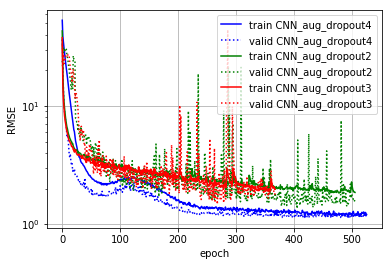

In [74]:
plot_loss([model3_4_hist, model3_2_hist, model3_3_hist],
          ['CNN_aug_dropout4','CNN_aug_dropout2','CNN_aug_dropout3'])

### Dropout brought valid in line with training, up the depth!

In [75]:
model4 = Sequential()
model4.add(Conv2D(16,
                 (3, 3),
                 activation='relu',
                input_shape=INPUT_SHAPE))
model4.add(BatchNormalization())
model4.add(MaxPooling2D(pool_size=(2, 2)))
model4.add(Conv2D(32,
                 (3, 3),
                 activation='relu',
                input_shape=INPUT_SHAPE))
model4.add(BatchNormalization())
model4.add(MaxPooling2D(pool_size=(2, 2)))
model4.add(Conv2D(filters=64,
                 kernel_size=(2, 2),
                 activation='relu'))
model4.add(BatchNormalization())
model4.add(MaxPooling2D(pool_size=(2, 2)))
model4.add(Conv2D(filters=128,
                 kernel_size=(2, 2),
                 activation='relu'))
model4.add(BatchNormalization())
model4.add(MaxPooling2D(pool_size=(2, 2)))
model4.add(Conv2D(filters=128,
                 kernel_size=(2, 2),
                 activation='relu'))
model4.add(BatchNormalization())
model4.add(MaxPooling2D(pool_size=(2, 2)))
model4.add(Flatten())
model4.add(Dense(500, activation = "relu"))
model4.add(BatchNormalization())
model4.add(Dense(500, activation = "relu"))
model4.add(BatchNormalization())
model4.add(Dropout(.3))
model4.add(Dense(30))
print(model4.summary())
model4_hist, model4 = fit_model(model4, data,
                                'CNN_deep',datagen,
                                patience=100)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 94, 94, 16)        160       
_________________________________________________________________
batch_normalization_32 (Batc (None, 94, 94, 16)        64        
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 47, 47, 16)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 45, 45, 32)        4640      
_________________________________________________________________
batch_normalization_33 (Batc (None, 45, 45, 32)        128       
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 22, 22, 32)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 21, 21, 64)        8256      
__________

53/53 [==============================] - 2s 47ms/step - loss: 0.0039 - val_loss: 0.0027
Epoch 130/1000
53/53 [==============================] - 2s 47ms/step - loss: 0.0037 - val_loss: 0.0028
Epoch 131/1000
53/53 [==============================] - 3s 48ms/step - loss: 0.0036 - val_loss: 0.0029
Epoch 132/1000
53/53 [==============================] - 2s 46ms/step - loss: 0.0036 - val_loss: 0.0025
Epoch 133/1000
53/53 [==============================] - 3s 48ms/step - loss: 0.0037 - val_loss: 0.0029
Epoch 134/1000
53/53 [==============================] - 2s 47ms/step - loss: 0.0036 - val_loss: 0.0028
Epoch 135/1000
53/53 [==============================] - 2s 46ms/step - loss: 0.0034 - val_loss: 0.0026
Epoch 136/1000
53/53 [==============================] - 2s 47ms/step - loss: 0.0034 - val_loss: 0.0027
Epoch 137/1000
53/53 [==============================] - 3s 47ms/step - loss: 0.0034 - val_loss: 0.0025
Epoch 138/1000
53/53 [==============================] - 3s 48ms/step - loss: 0.0034 - va

53/53 [==============================] - 3s 49ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 288/1000
53/53 [==============================] - 3s 48ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 289/1000
53/53 [==============================] - 3s 48ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 290/1000
53/53 [==============================] - 2s 47ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 291/1000
53/53 [==============================] - 3s 48ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 292/1000
53/53 [==============================] - 3s 48ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 293/1000
53/53 [==============================] - 3s 49ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 294/1000
53/53 [==============================] - 3s 49ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 295/1000
53/53 [==============================] - 3s 48ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 296/1000
53/53 [==============================] - 3s 47ms/step - loss: 0.0012 - va

53/53 [==============================] - 2s 47ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 445/1000
53/53 [==============================] - 2s 47ms/step - loss: 0.0011 - val_loss: 9.9241e-04
Epoch 446/1000
53/53 [==============================] - 2s 46ms/step - loss: 9.8872e-04 - val_loss: 9.5194e-04
Epoch 447/1000
53/53 [==============================] - 2s 47ms/step - loss: 9.7409e-04 - val_loss: 0.0010
Epoch 448/1000
53/53 [==============================] - 3s 48ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 449/1000
53/53 [==============================] - 3s 48ms/step - loss: 9.9622e-04 - val_loss: 9.9080e-04
Epoch 450/1000
53/53 [==============================] - 3s 49ms/step - loss: 9.7809e-04 - val_loss: 9.7795e-04
Epoch 451/1000
53/53 [==============================] - 3s 48ms/step - loss: 9.9390e-04 - val_loss: 0.0011
Epoch 452/1000
53/53 [==============================] - 3s 48ms/step - loss: 0.0010 - val_loss: 0.0011
Epoch 453/1000
53/53 [==============================

Epoch 520/1000
53/53 [==============================] - 3s 48ms/step - loss: 9.7282e-04 - val_loss: 9.9632e-04
Epoch 521/1000
53/53 [==============================] - 3s 48ms/step - loss: 9.8987e-04 - val_loss: 9.8385e-04
Epoch 522/1000
53/53 [==============================] - 3s 47ms/step - loss: 9.4845e-04 - val_loss: 9.2950e-04
Epoch 523/1000
53/53 [==============================] - 3s 48ms/step - loss: 9.7851e-04 - val_loss: 0.0010
Epoch 524/1000
53/53 [==============================] - 3s 48ms/step - loss: 9.4508e-04 - val_loss: 9.3448e-04
Epoch 525/1000
53/53 [==============================] - 3s 48ms/step - loss: 8.9997e-04 - val_loss: 0.0010
Epoch 526/1000
53/53 [==============================] - 3s 49ms/step - loss: 9.6409e-04 - val_loss: 0.0010
Epoch 527/1000
53/53 [==============================] - 2s 47ms/step - loss: 9.6026e-04 - val_loss: 9.9558e-04
Epoch 528/1000
53/53 [==============================] - 3s 49ms/step - loss: 9.8687e-04 - val_loss: 0.0011
Epoch 529/1000
53

53/53 [==============================] - 3s 48ms/step - loss: 8.8970e-04 - val_loss: 0.0010
Epoch 669/1000
53/53 [==============================] - 3s 48ms/step - loss: 8.9254e-04 - val_loss: 9.3099e-04
Epoch 670/1000
53/53 [==============================] - 3s 48ms/step - loss: 8.6300e-04 - val_loss: 9.1226e-04
Epoch 671/1000
53/53 [==============================] - 2s 46ms/step - loss: 9.2286e-04 - val_loss: 9.1502e-04
Epoch 672/1000
53/53 [==============================] - 2s 46ms/step - loss: 9.1207e-04 - val_loss: 9.4140e-04
Epoch 673/1000
53/53 [==============================] - 2s 47ms/step - loss: 8.7758e-04 - val_loss: 9.7614e-04
Epoch 674/1000
53/53 [==============================] - 2s 47ms/step - loss: 9.1332e-04 - val_loss: 0.0012
Epoch 675/1000
53/53 [==============================] - 3s 48ms/step - loss: 9.1082e-04 - val_loss: 9.6625e-04
Epoch 676/1000
53/53 [==============================] - 2s 47ms/step - loss: 8.7696e-04 - val_loss: 8.9428e-04
Epoch 677/1000
53/53 [==

### Using a model from the zoo

In [76]:
# force grayscale into 3 channels
X_train_3chan = np.tile(X_train,(1,1,1,3))
X_test_3chan = np.tile(X_test,(1,1,1,3))
data_zoo=[X_train_3chan, X_test_3chan, y_train, y_test]

In [77]:
datagen_zoo = CustImageDataGenerator(
    rotation_range=5. #degrees
     ,horizontal_flip=True
     ,width_shift_range=.05 # percent of image width
     ,height_shift_range=.05 # percent of image height
    ).flow(X_train_3chan,y_train,whichlabels=list(labels), batch_size=32)

earlystop = EarlyStopping(monitor='val_loss',
                                 patience=100,
                                 verbose=1,
                                 mode="auto")
callbacks = [earlystop]

In [78]:
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K
            


# create the base pre-trained model
base_model = InceptionV3(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# add the keypoints detection layer
predictions = Dense(30)(x)

# this is the model we will train
model_zoo = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
model_zoo.compile(loss='mse', optimizer=Nadam())


print(model_zoo.summary())
model_zoo_hist, model_zoo = fit_model(model_zoo, data_zoo,
                                'zoo',datagen_zoo,
                                patience=100)


87916544/87910968 [==============================] - 1s 0us/step
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_24 (Conv2D)              (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_39 (BatchNo (None, None, None, 3 96          conv2d_24[0][0]                  
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, None, 3 0           batch_normalization_39[0][0]     
____________________________________________

Epoch 1/1000
53/53 [==============================] - 9s 178ms/step - loss: 0.0679 - val_loss: 0.6806
Epoch 2/1000
53/53 [==============================] - 6s 107ms/step - loss: 0.0177 - val_loss: 0.5101
Epoch 3/1000
53/53 [==============================] - 6s 107ms/step - loss: 0.0150 - val_loss: 0.4786
Epoch 4/1000
53/53 [==============================] - 6s 107ms/step - loss: 0.0136 - val_loss: 0.4012
Epoch 5/1000
53/53 [==============================] - 6s 107ms/step - loss: 0.0128 - val_loss: 0.3979
Epoch 6/1000
53/53 [==============================] - 6s 106ms/step - loss: 0.0122 - val_loss: 0.3530
Epoch 7/1000
53/53 [==============================] - 6s 104ms/step - loss: 0.0117 - val_loss: 0.2907
Epoch 8/1000
53/53 [==============================] - 6s 104ms/step - loss: 0.0110 - val_loss: 0.2759
Epoch 9/1000
53/53 [==============================] - 6s 104ms/step - loss: 0.0109 - val_loss: 0.2488
Epoch 10/1000
53/53 [==============================] - 5s 103ms/step - loss: 0.010

53/53 [==============================] - 5s 95ms/step - loss: 0.0072 - val_loss: 0.0069
Epoch 161/1000
53/53 [==============================] - 5s 95ms/step - loss: 0.0072 - val_loss: 0.0076
Epoch 162/1000
53/53 [==============================] - 5s 95ms/step - loss: 0.0071 - val_loss: 0.0066
Epoch 163/1000
53/53 [==============================] - 5s 96ms/step - loss: 0.0074 - val_loss: 0.0092
Epoch 164/1000
53/53 [==============================] - 6s 109ms/step - loss: 0.0071 - val_loss: 0.0073
Epoch 165/1000
53/53 [==============================] - 6s 107ms/step - loss: 0.0072 - val_loss: 0.0071
Epoch 166/1000
53/53 [==============================] - 6s 107ms/step - loss: 0.0073 - val_loss: 0.0074
Epoch 167/1000
53/53 [==============================] - 6s 105ms/step - loss: 0.0071 - val_loss: 0.0075
Epoch 168/1000
53/53 [==============================] - 6s 105ms/step - loss: 0.0073 - val_loss: 0.0099
Epoch 169/1000
53/53 [==============================] - 6s 104ms/step - loss: 0.007

In [79]:
# at this point, the top layers are well trained and we can start fine-tuning
# convolutional layers from inception V3. We will freeze the bottom N layers
# and train the remaining top layers.

# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(base_model.layers):
    print(i, layer.name)

0 input_1
1 conv2d_24
2 batch_normalization_39
3 activation_1
4 conv2d_25
5 batch_normalization_40
6 activation_2
7 conv2d_26
8 batch_normalization_41
9 activation_3
10 max_pooling2d_24
11 conv2d_27
12 batch_normalization_42
13 activation_4
14 conv2d_28
15 batch_normalization_43
16 activation_5
17 max_pooling2d_25
18 conv2d_32
19 batch_normalization_47
20 activation_9
21 conv2d_30
22 conv2d_33
23 batch_normalization_45
24 batch_normalization_48
25 activation_7
26 activation_10
27 average_pooling2d_1
28 conv2d_29
29 conv2d_31
30 conv2d_34
31 conv2d_35
32 batch_normalization_44
33 batch_normalization_46
34 batch_normalization_49
35 batch_normalization_50
36 activation_6
37 activation_8
38 activation_11
39 activation_12
40 mixed0
41 conv2d_39
42 batch_normalization_54
43 activation_16
44 conv2d_37
45 conv2d_40
46 batch_normalization_52
47 batch_normalization_55
48 activation_14
49 activation_17
50 average_pooling2d_2
51 conv2d_36
52 conv2d_38
53 conv2d_41
54 conv2d_42
55 batch_normalizati

In [80]:
# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
for layer in model_zoo.layers[:249]:
    layer.trainable = False
for layer in model_zoo.layers[249:]:
    layer.trainable = True

# we need to recompile the model for these modifications to take effect
model_zoo.compile(loss='mse', optimizer=Nadam())

# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers
model_zoo_hist2, model_zoo = fit_model(model_zoo, data_zoo,
                                'zoo2',datagen_zoo,
                                patience=1000)

Epoch 1/1000
53/53 [==============================] - 12s 234ms/step - loss: 0.0073 - val_loss: 0.0045
Epoch 2/1000
53/53 [==============================] - 6s 117ms/step - loss: 0.0068 - val_loss: 0.0117
Epoch 3/1000
53/53 [==============================] - 6s 117ms/step - loss: 0.0066 - val_loss: 0.0113
Epoch 4/1000
53/53 [==============================] - 6s 119ms/step - loss: 0.0062 - val_loss: 0.0089
Epoch 5/1000
53/53 [==============================] - 6s 119ms/step - loss: 0.0062 - val_loss: 0.0134
Epoch 6/1000
53/53 [==============================] - 6s 117ms/step - loss: 0.0061 - val_loss: 0.0171
Epoch 7/1000
53/53 [==============================] - 6s 119ms/step - loss: 0.0057 - val_loss: 0.0139
Epoch 8/1000
53/53 [==============================] - 6s 117ms/step - loss: 0.0058 - val_loss: 0.0173
Epoch 9/1000
53/53 [==============================] - 6s 117ms/step - loss: 0.0056 - val_loss: 0.0137
Epoch 10/1000
53/53 [==============================] - 6s 117ms/step - loss: 0.00

53/53 [==============================] - 6s 116ms/step - loss: 0.0034 - val_loss: 0.0079
Epoch 160/1000
53/53 [==============================] - 6s 116ms/step - loss: 0.0033 - val_loss: 0.0070
Epoch 161/1000
53/53 [==============================] - 6s 116ms/step - loss: 0.0034 - val_loss: 0.0063
Epoch 162/1000
53/53 [==============================] - 6s 115ms/step - loss: 0.0034 - val_loss: 0.0066
Epoch 163/1000
53/53 [==============================] - 6s 115ms/step - loss: 0.0033 - val_loss: 0.0071
Epoch 164/1000
53/53 [==============================] - 6s 119ms/step - loss: 0.0035 - val_loss: 0.0076
Epoch 165/1000
53/53 [==============================] - 6s 118ms/step - loss: 0.0033 - val_loss: 0.0067
Epoch 166/1000
53/53 [==============================] - 6s 119ms/step - loss: 0.0033 - val_loss: 0.0071
Epoch 167/1000
53/53 [==============================] - 6s 118ms/step - loss: 0.0034 - val_loss: 0.0069
Epoch 168/1000
53/53 [==============================] - 6s 118ms/step - loss: 0

Epoch 238/1000
53/53 [==============================] - 6s 118ms/step - loss: 0.0031 - val_loss: 0.0072
Epoch 239/1000
53/53 [==============================] - 6s 116ms/step - loss: 0.0031 - val_loss: 0.0078
Epoch 240/1000
53/53 [==============================] - 6s 116ms/step - loss: 0.0031 - val_loss: 0.0084
Epoch 241/1000
53/53 [==============================] - 6s 116ms/step - loss: 0.0030 - val_loss: 0.0086
Epoch 242/1000
53/53 [==============================] - 6s 116ms/step - loss: 0.0031 - val_loss: 0.0082
Epoch 243/1000
53/53 [==============================] - 6s 116ms/step - loss: 0.0031 - val_loss: 0.0081
Epoch 244/1000
53/53 [==============================] - 6s 117ms/step - loss: 0.0031 - val_loss: 0.0095
Epoch 245/1000
53/53 [==============================] - 6s 116ms/step - loss: 0.0031 - val_loss: 0.0084
Epoch 246/1000
53/53 [==============================] - 6s 116ms/step - loss: 0.0030 - val_loss: 0.0092
Epoch 247/1000
53/53 [==============================] - 6s 116ms

Epoch 317/1000
53/53 [==============================] - 6s 115ms/step - loss: 0.0029 - val_loss: 0.0074
Epoch 318/1000
53/53 [==============================] - 6s 116ms/step - loss: 0.0030 - val_loss: 0.0081
Epoch 319/1000
53/53 [==============================] - 6s 115ms/step - loss: 0.0029 - val_loss: 0.0074
Epoch 320/1000
53/53 [==============================] - 6s 115ms/step - loss: 0.0029 - val_loss: 0.0072
Epoch 321/1000
53/53 [==============================] - 6s 116ms/step - loss: 0.0029 - val_loss: 0.0077
Epoch 322/1000
53/53 [==============================] - 6s 116ms/step - loss: 0.0029 - val_loss: 0.0080
Epoch 323/1000
53/53 [==============================] - 6s 115ms/step - loss: 0.0029 - val_loss: 0.0076
Epoch 324/1000
53/53 [==============================] - 6s 115ms/step - loss: 0.0031 - val_loss: 0.0074
Epoch 325/1000
53/53 [==============================] - 6s 115ms/step - loss: 0.0029 - val_loss: 0.0098
Epoch 326/1000
53/53 [==============================] - 6s 119ms

Epoch 396/1000
53/53 [==============================] - 6s 119ms/step - loss: 0.0029 - val_loss: 0.0089
Epoch 397/1000
53/53 [==============================] - 6s 116ms/step - loss: 0.0028 - val_loss: 0.0087
Epoch 398/1000
53/53 [==============================] - 6s 118ms/step - loss: 0.0028 - val_loss: 0.0082
Epoch 399/1000
53/53 [==============================] - 6s 117ms/step - loss: 0.0029 - val_loss: 0.0086
Epoch 400/1000
53/53 [==============================] - 6s 117ms/step - loss: 0.0027 - val_loss: 0.0081
Epoch 401/1000
53/53 [==============================] - 6s 117ms/step - loss: 0.0028 - val_loss: 0.0085
Epoch 402/1000
53/53 [==============================] - 6s 116ms/step - loss: 0.0028 - val_loss: 0.0082
Epoch 403/1000
53/53 [==============================] - 6s 116ms/step - loss: 0.0028 - val_loss: 0.0067
Epoch 404/1000
53/53 [==============================] - 6s 117ms/step - loss: 0.0027 - val_loss: 0.0074
Epoch 405/1000
53/53 [==============================] - 6s 116ms

Epoch 475/1000
53/53 [==============================] - 6s 116ms/step - loss: 0.0028 - val_loss: 0.0082
Epoch 476/1000
53/53 [==============================] - 6s 115ms/step - loss: 0.0027 - val_loss: 0.0073
Epoch 477/1000
53/53 [==============================] - 6s 116ms/step - loss: 0.0026 - val_loss: 0.0080
Epoch 478/1000
53/53 [==============================] - 6s 116ms/step - loss: 0.0026 - val_loss: 0.0081
Epoch 479/1000
53/53 [==============================] - 6s 118ms/step - loss: 0.0027 - val_loss: 0.0079
Epoch 480/1000
53/53 [==============================] - 6s 116ms/step - loss: 0.0026 - val_loss: 0.0082
Epoch 481/1000
53/53 [==============================] - 6s 116ms/step - loss: 0.0027 - val_loss: 0.0086
Epoch 482/1000
53/53 [==============================] - 6s 116ms/step - loss: 0.0028 - val_loss: 0.0074
Epoch 483/1000
53/53 [==============================] - 6s 116ms/step - loss: 0.0026 - val_loss: 0.0074
Epoch 484/1000
53/53 [==============================] - 6s 115ms

Epoch 554/1000
53/53 [==============================] - 6s 117ms/step - loss: 0.0026 - val_loss: 0.0094
Epoch 555/1000
53/53 [==============================] - 6s 117ms/step - loss: 0.0026 - val_loss: 0.0088
Epoch 556/1000
53/53 [==============================] - 6s 115ms/step - loss: 0.0026 - val_loss: 0.0087
Epoch 557/1000
53/53 [==============================] - 7s 123ms/step - loss: 0.0027 - val_loss: 0.0094
Epoch 558/1000
53/53 [==============================] - 6s 116ms/step - loss: 0.0025 - val_loss: 0.0087
Epoch 559/1000
53/53 [==============================] - 6s 117ms/step - loss: 0.0026 - val_loss: 0.0090
Epoch 560/1000
53/53 [==============================] - 6s 118ms/step - loss: 0.0026 - val_loss: 0.0089
Epoch 561/1000
53/53 [==============================] - 6s 118ms/step - loss: 0.0026 - val_loss: 0.0085
Epoch 562/1000
53/53 [==============================] - 6s 117ms/step - loss: 0.0026 - val_loss: 0.0093
Epoch 563/1000
53/53 [==============================] - 7s 124ms

Epoch 633/1000
53/53 [==============================] - 6s 117ms/step - loss: 0.0026 - val_loss: 0.0085
Epoch 634/1000
53/53 [==============================] - 6s 116ms/step - loss: 0.0026 - val_loss: 0.0082
Epoch 635/1000
53/53 [==============================] - 6s 117ms/step - loss: 0.0026 - val_loss: 0.0080
Epoch 636/1000
53/53 [==============================] - 6s 115ms/step - loss: 0.0025 - val_loss: 0.0084
Epoch 637/1000
53/53 [==============================] - 6s 117ms/step - loss: 0.0026 - val_loss: 0.0081
Epoch 638/1000
53/53 [==============================] - 6s 116ms/step - loss: 0.0025 - val_loss: 0.0086
Epoch 639/1000
53/53 [==============================] - 6s 118ms/step - loss: 0.0027 - val_loss: 0.0059
Epoch 640/1000
53/53 [==============================] - 6s 116ms/step - loss: 0.0026 - val_loss: 0.0077
Epoch 641/1000
53/53 [==============================] - 6s 116ms/step - loss: 0.0026 - val_loss: 0.0093
Epoch 642/1000
53/53 [==============================] - 6s 116ms

Epoch 712/1000
53/53 [==============================] - 6s 117ms/step - loss: 0.0025 - val_loss: 0.0079
Epoch 713/1000
53/53 [==============================] - 6s 117ms/step - loss: 0.0024 - val_loss: 0.0083
Epoch 714/1000
53/53 [==============================] - 6s 116ms/step - loss: 0.0024 - val_loss: 0.0080
Epoch 715/1000
53/53 [==============================] - 6s 116ms/step - loss: 0.0025 - val_loss: 0.0080
Epoch 716/1000
53/53 [==============================] - 6s 116ms/step - loss: 0.0025 - val_loss: 0.0078
Epoch 717/1000
53/53 [==============================] - 6s 116ms/step - loss: 0.0025 - val_loss: 0.0092
Epoch 718/1000
53/53 [==============================] - 6s 116ms/step - loss: 0.0025 - val_loss: 0.0088
Epoch 719/1000
53/53 [==============================] - 6s 117ms/step - loss: 0.0024 - val_loss: 0.0086
Epoch 720/1000
53/53 [==============================] - 6s 117ms/step - loss: 0.0024 - val_loss: 0.0075
Epoch 721/1000
53/53 [==============================] - 6s 116ms

Epoch 791/1000
53/53 [==============================] - 6s 116ms/step - loss: 0.0025 - val_loss: 0.0087
Epoch 792/1000
53/53 [==============================] - 6s 117ms/step - loss: 0.0024 - val_loss: 0.0098
Epoch 793/1000
53/53 [==============================] - 6s 117ms/step - loss: 0.0024 - val_loss: 0.0087
Epoch 794/1000
53/53 [==============================] - 6s 116ms/step - loss: 0.0024 - val_loss: 0.0089
Epoch 795/1000
53/53 [==============================] - 6s 116ms/step - loss: 0.0024 - val_loss: 0.0090
Epoch 796/1000
53/53 [==============================] - 6s 115ms/step - loss: 0.0024 - val_loss: 0.0081
Epoch 797/1000
53/53 [==============================] - 6s 116ms/step - loss: 0.0023 - val_loss: 0.0092
Epoch 798/1000
53/53 [==============================] - 6s 116ms/step - loss: 0.0024 - val_loss: 0.0088
Epoch 799/1000
53/53 [==============================] - 6s 116ms/step - loss: 0.0024 - val_loss: 0.0088
Epoch 800/1000
53/53 [==============================] - 6s 115ms

Epoch 870/1000
53/53 [==============================] - 6s 119ms/step - loss: 0.0024 - val_loss: 0.0085
Epoch 871/1000
53/53 [==============================] - 6s 117ms/step - loss: 0.0024 - val_loss: 0.0073
Epoch 872/1000
53/53 [==============================] - 6s 118ms/step - loss: 0.0022 - val_loss: 0.0080
Epoch 873/1000
53/53 [==============================] - 6s 117ms/step - loss: 0.0024 - val_loss: 0.0091
Epoch 874/1000
53/53 [==============================] - 6s 118ms/step - loss: 0.0023 - val_loss: 0.0094
Epoch 875/1000
53/53 [==============================] - 6s 119ms/step - loss: 0.0023 - val_loss: 0.0085
Epoch 876/1000
53/53 [==============================] - 6s 116ms/step - loss: 0.0023 - val_loss: 0.0086
Epoch 877/1000
53/53 [==============================] - 6s 116ms/step - loss: 0.0023 - val_loss: 0.0076
Epoch 878/1000
53/53 [==============================] - 6s 116ms/step - loss: 0.0023 - val_loss: 0.0088
Epoch 879/1000
53/53 [==============================] - 6s 116ms

Epoch 949/1000
53/53 [==============================] - 6s 117ms/step - loss: 0.0022 - val_loss: 0.0072
Epoch 950/1000
53/53 [==============================] - 6s 116ms/step - loss: 0.0024 - val_loss: 0.0078
Epoch 951/1000
53/53 [==============================] - 6s 116ms/step - loss: 0.0023 - val_loss: 0.0077
Epoch 952/1000
53/53 [==============================] - 6s 116ms/step - loss: 0.0023 - val_loss: 0.0075
Epoch 953/1000
53/53 [==============================] - 6s 117ms/step - loss: 0.0024 - val_loss: 0.0075
Epoch 954/1000
53/53 [==============================] - 6s 116ms/step - loss: 0.0023 - val_loss: 0.0070
Epoch 955/1000
53/53 [==============================] - 6s 117ms/step - loss: 0.0023 - val_loss: 0.0073
Epoch 956/1000
53/53 [==============================] - 6s 116ms/step - loss: 0.0023 - val_loss: 0.0070
Epoch 957/1000
53/53 [==============================] - 6s 119ms/step - loss: 0.0024 - val_loss: 0.0069
Epoch 958/1000
53/53 [==============================] - 6s 117ms

## Create Predictions
### Load the Testing Time Images

In [13]:
out_images, _ , _ = loader(test=True, seed=None, keeplabels=None)

### Create the Preditions

In [24]:
final_model = model2
prediction = final_model.predict(out_images)

### Plot some example predictions

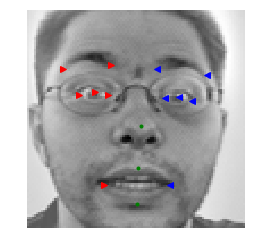

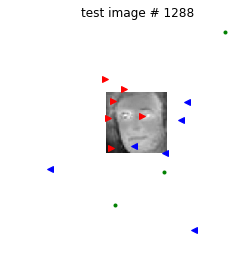

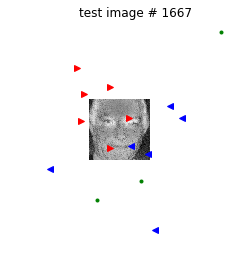

In [25]:
# first image
plot_image(out_images[0], 48*prediction[0]+48, labels)



# images that have labels outside the image
for i in np.where(np.max(np.abs(prediction),axis=1)>1)[0]:
    plot_image(out_images[i],
        48*prediction[i]+48, labels,title='test image # ' + str(i))




### Put the predictions into the submission format

In [26]:
IdLookupTable = read_csv('/home/ubuntu/w207/data/IdLookupTable.csv')
IdLookupTable.head()

,RowId,ImageId,FeatureName,Location
0,1,1,left_eye_center_x,NaN
1,2,1,left_eye_center_y,NaN
2,3,1,right_eye_center_x,NaN
3,4,1,right_eye_center_y,NaN
4,5,1,left_eye_inner_corner_x,NaN


In [27]:
label_locs = {}
for i, label in enumerate(labels):
    label_locs[label]=i

IdLookupTable['test'] = IdLookupTable['FeatureName'].replace(label_locs)
IdLookupTable['Location'] = (48*prediction[IdLookupTable['ImageId']-1,
                                       IdLookupTable['test']]) + 48

IdLookupTable['Location'] = (IdLookupTable['Location'].
                             where(IdLookupTable['Location']<=96, 96).
                             where(IdLookupTable['Location']>=0, 0)
                            )
IdLookupTable.head()

,RowId,ImageId,FeatureName,Location,test
0,1,1,left_eye_center_x,66.491943,0
1,2,1,left_eye_center_y,37.709721,1
2,3,1,right_eye_center_x,29.392212,20
3,4,1,right_eye_center_y,35.723457,21
4,5,1,left_eye_inner_corner_x,60.634697,2


In [28]:
Submission = IdLookupTable[['RowId','Location']]
Submission.head()

,RowId,Location
0,1,66.491943
1,2,37.709721
2,3,29.392212
3,4,35.723457
4,5,60.634697


In [29]:
Submission.to_csv(path_or_buf='./Submissions/CNN_wdatAugment.csv',
                  index=False)

In [30]:
Submission.describe()

,RowId,Location
count,27124.000000,27124.000000
mean,13562.500000,48.548576
std,7830.168687,17.955484
min,1.000000,0.000000
25%,6781.750000,35.242485
50%,13562.500000,45.617132
75%,20343.250000,62.963644
max,27124.000000,96.000000
